In [4]:
#! pip install mir_eval

In [ ]:
from keras import Sequential

In [6]:
import numpy as np
import os
import glob
import librosa
import random
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from keras import Sequential, losses, models, optimizers, regularizers
from tensorflow.keras.utils import Sequence, to_categorical
from keras.activations import relu, softmax
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization


#from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from sklearn.metrics import confusion_matrix
from keras.models import load_model

from scipy import signal

import librosa
import librosa.display

# We'll need IPython.display's Audio widget
from IPython.display import Audio

# We'll also use `mir_eval` to synthesize a signal for us
import mir_eval.sonify

# Notes 

<Figure size 2500x1500 with 0 Axes>

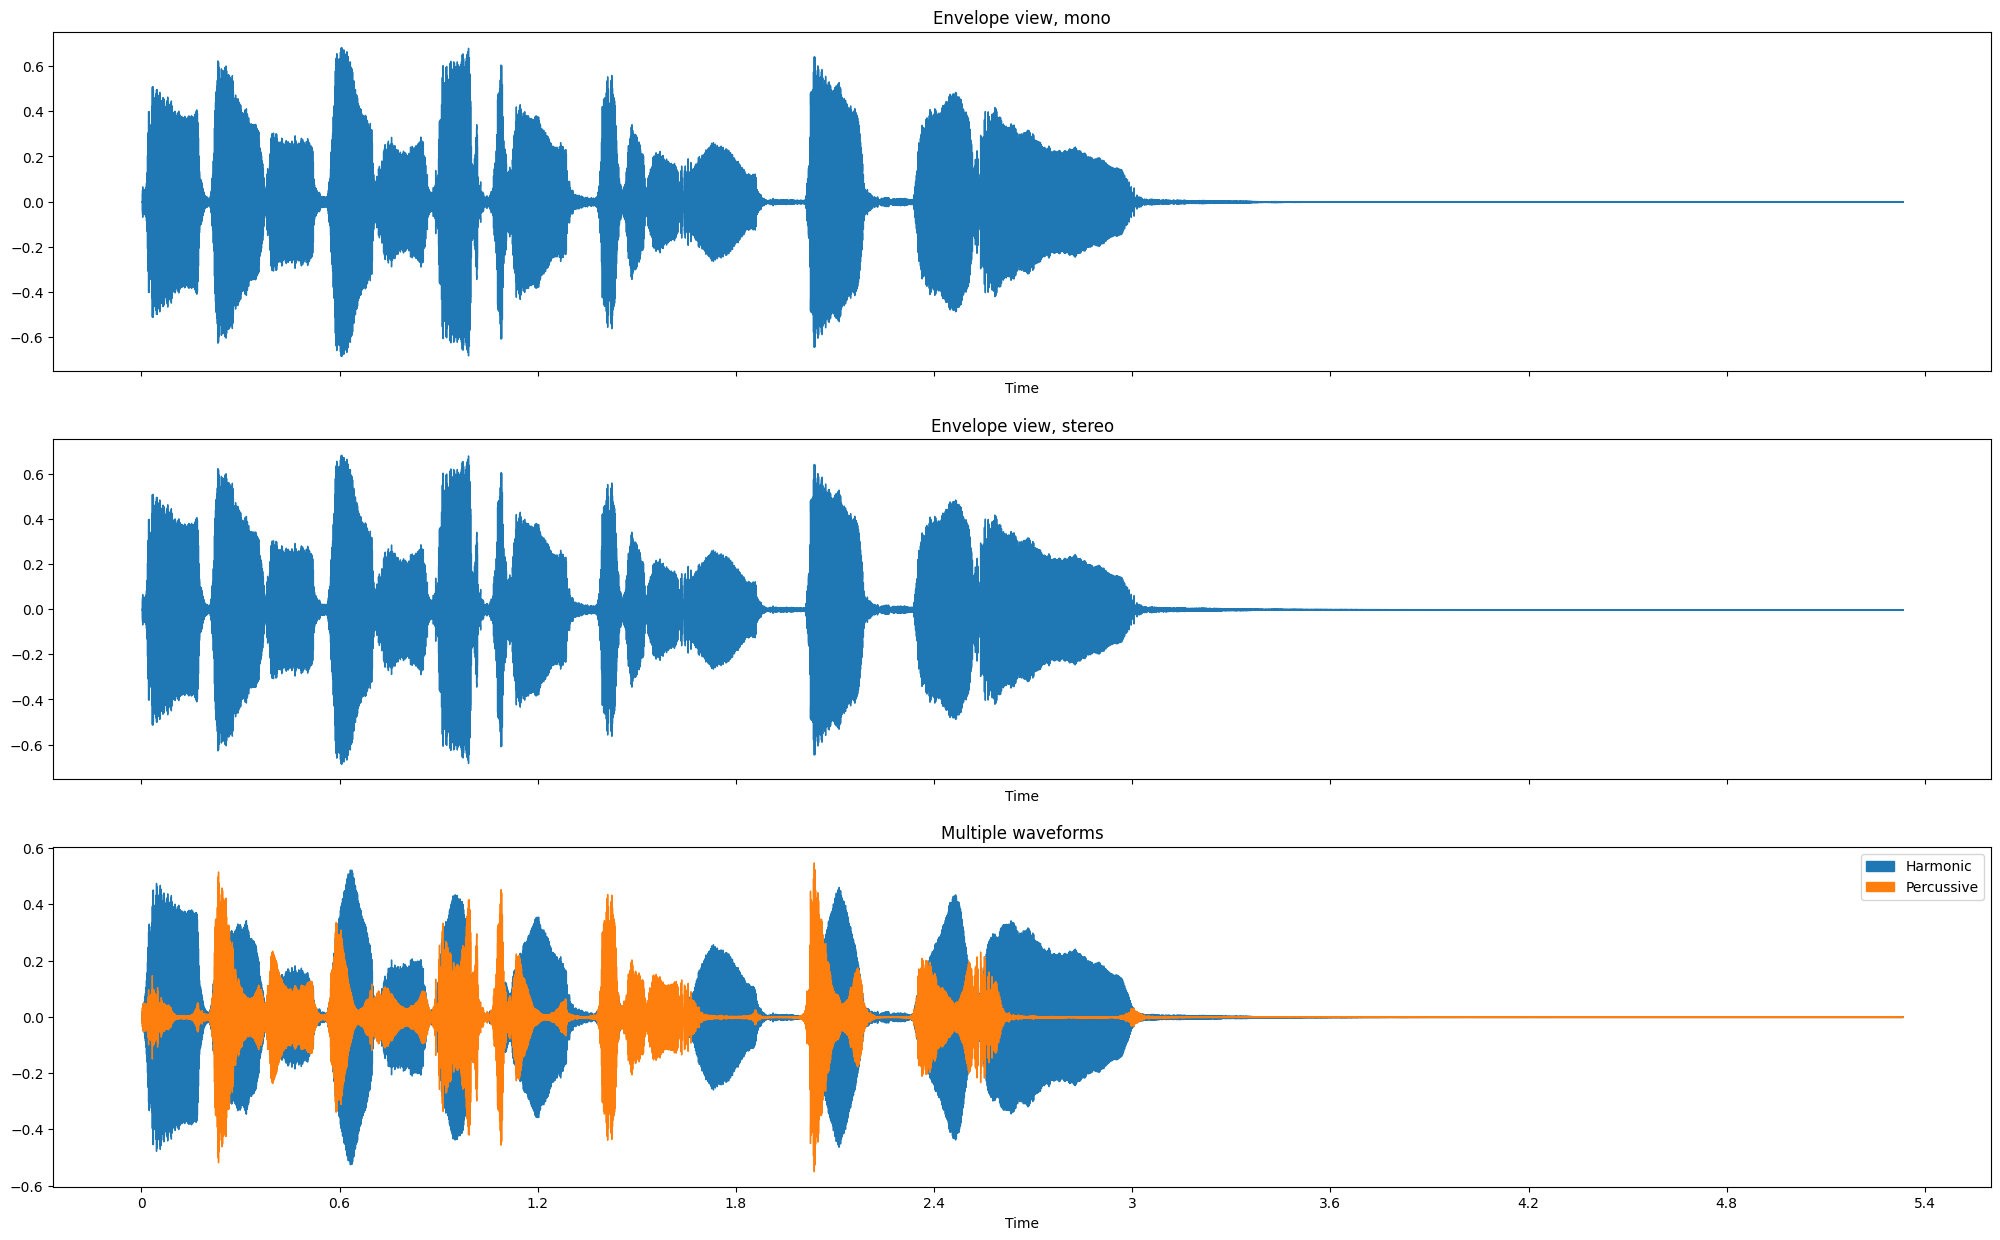

In [86]:
import traitlets
filename = librosa.example('trumpet')
sample_rate = 22050 # this is the sample rate for playing the audio, not the actual sampling rate used to convert sound into digital 
y, sr = librosa.load(filename)
plt.figure(figsize=(25,15))
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(25,15))
librosa.display.waveshow(y, sr=sr, ax=ax[0])
librosa.display.waveshow(y, sr=sr, ax=ax[1])

#diving the audio into the prevussive and the harmonic components
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, ax=ax[2], label='Percussive')

ax[0].set(title='Envelope view, mono')
ax[1].set(title='Envelope view, stereo')
ax[2].set(title='Multiple waveforms')
ax[2].legend()
Audio(data=y, rate = sample_rate)

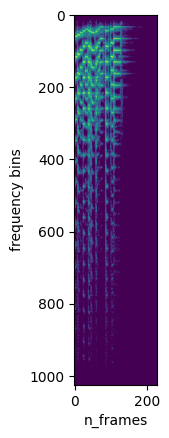

In [100]:
n_fft=2048
#outputs (num of frequency bins = 1+n_fft/2, n_frames=len(y)//hop_length)
stft=librosa.stft(y, n_fft=n_fft, hop_length=n_fft//4) #note that this is complex

#converting the complex numbers into magnitude and phase
S, phase=librosa.magphase(stft)

#convertin the magnitude in terms of dB
Sdb=librosa.amplitude_to_db(np.abs(S), ref=np.max)
#print(f'The magnitude matrix is{S}')
#print(f'The phase is {phase}')

#Display the magnitude of the stft matrix produced here.
#plt.figure(figsize=(25,30))
plt.xlabel('n_frames')
plt.ylabel('frequency bins')
plt.imshow(Sdb)

# 

In [180]:
Sdb.shape

(1025, 230)

In [236]:
y.shape[0]//512 + 1

230

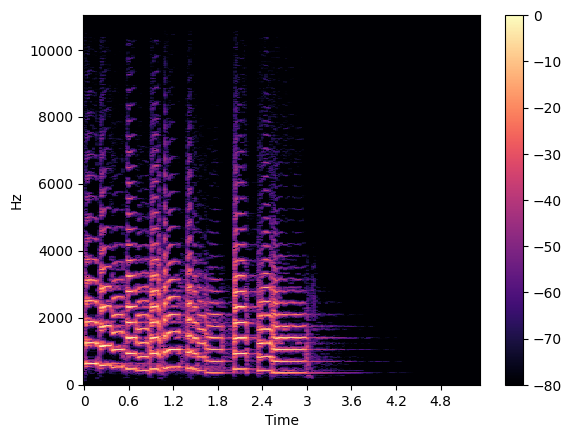

In [98]:
plt.figure()
librosa.display.specshow(Sdb, x_axis='time', y_axis='linear')
plt.colorbar()

# Creating a spectrogram
In this part of the notebook, we will create a spectrogram from scratch.

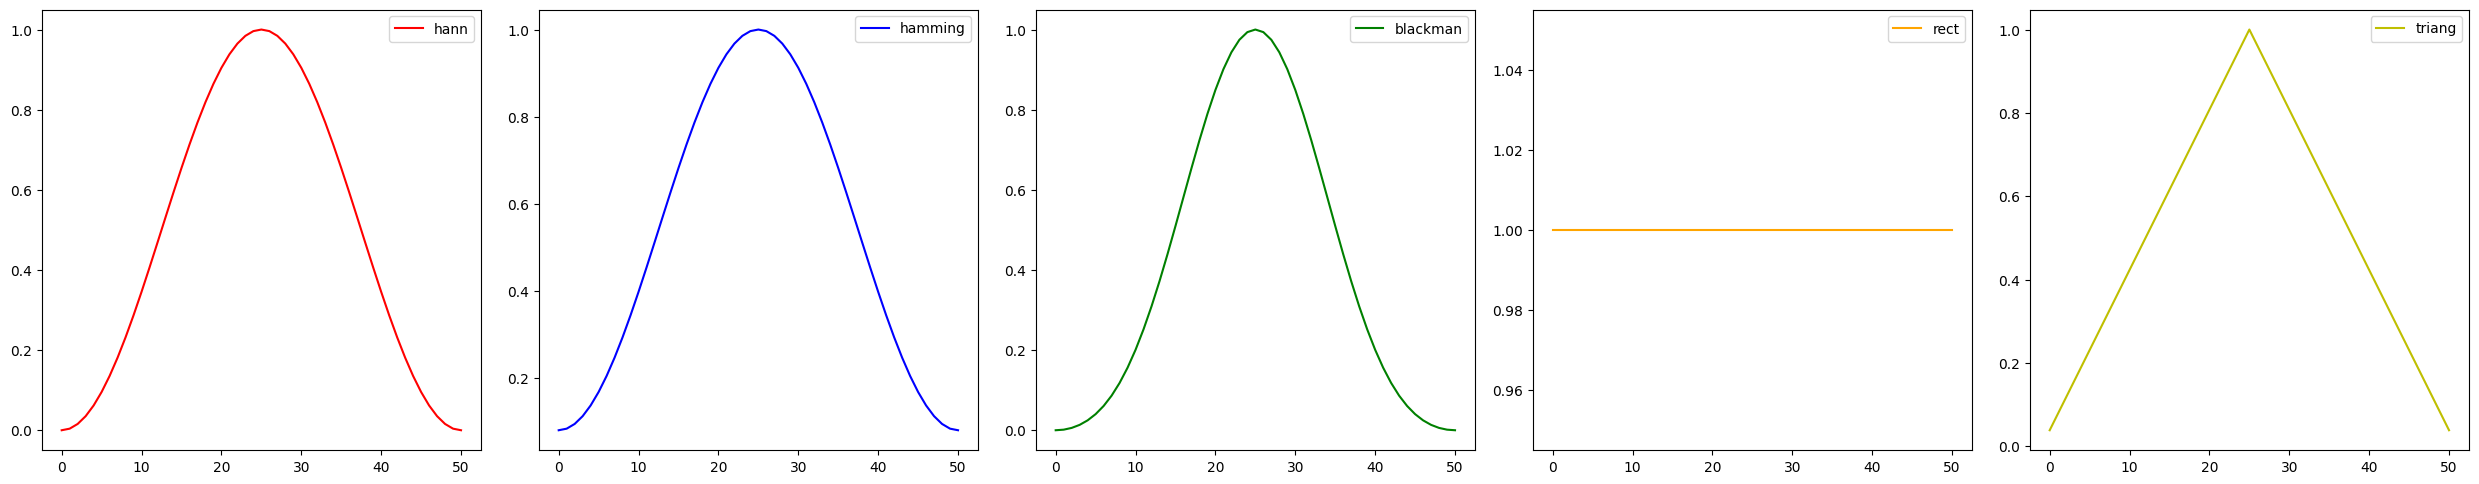

In [211]:
size=51
fig,ax=plt.subplots(1,5,figsize=(25,5))
fig.tight_layout()

ax[0].plot(signal.windows.hann(size), 'r', label='hann')
ax[1].plot(signal.windows.hamming(size), 'b', label='hamming')
ax[2].plot(signal.windows.blackman(size),'g', label='blackman')
ax[3].plot(signal.windows.boxcar(size),'orange', label='rect')
ax[4].plot(signal.windows.triang(size),'y', label='triang')

for i in range(5):
  ax[i].legend()

In [246]:
def make_segments(y,window_length,hop_length,window_name):
  '''returns each segment of the audio'''
  
  window_type={'hann':signal.windows.hann(window_length),
               'hamming':signal.windows.hamming(window_length),
               'blackman':signal.windows.blackman(window_length),
               'rect':signal.windows.boxcar(window_length),
               'triang':signal.windows.triang(window_length)
               }

  segment_lst=[]
  window=window_type[window_name]
  #num_segments=1+(len(y)-window_length)//hop_length
  num_segments=1+len(y)//hop_length
  for k in range(num_segments):
    start=k*hop_length
    end=start+window_length
    segment=y[start:end]
    if len(segment)!=window_length:
        zero_pad=np.zeros(window_length-len(segment))
        segment=np.concatenate([segment,zero_pad])
        segment=segment*window
        segment_lst.append(segment)
    else:
        segment=segment*window
        segment_lst.append(segment)
        
  return segment_lst

In [245]:
a=np.zeros(5)
b=np.ones(10)
np.concatenate([a,b])

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [239]:
def STFT(segments,sample_rate,n_fft):
    fft_segments=[]
    #n_fft_new=1+n_fft//2
    freq_bins=np.linspace(0,sample_rate,n_fft)
    for segment in segments:
        fft_segment=np.fft.fft(segment)
        fft_segments.append(fft_segment)
    return fft_segments,freq_bins

$$dB = 20*\log_{10}(\frac{A1}{A2})$$

60dB is equivalent to saying that $\frac{A1}{A2}=1000$. 

In [249]:
segments=make_segments(y=y,window_length=2048,hop_length=2048//4, window_name='hann')
len(segments)

230

Text(0.5, 0, 'frequency')

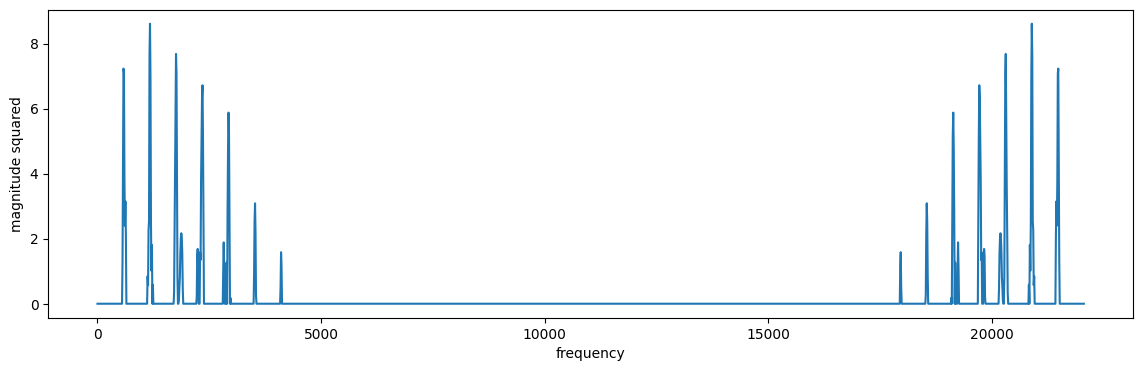

In [248]:
segments=make_segments(y=y,window_length=2048,hop_length=2048//4, window_name='hann')
w_stft, w_freq = STFT(segments=segments,sample_rate=22050,n_fft=2048)

plt.figure(figsize=(14,4))
plt.plot(w_freq, np.log(np.maximum(1,abs(w_stft[11])**2)))
plt.ylabel('magnitude squared')
plt.xlabel('frequency')

In [250]:
len(segments)

230

We divide by the minimum because the it is essentially, divinding the magnitude by the max, which we set as our reference amplitude. Multiplying by a thousand will ensure that everything will be above 60dB. 

In [274]:
# def make_spectrogram(stft_segments,max_freq,n_fft,thres_db,sample_rate):
#     mag_stft_segments=np.absolute(stft_segments)
#     ref_mag=np.max(mag_stft_segments)
    
#     #reference amplitude
#     ref_amp=10**(thres_db/20)
#     mag_stft_segments=ref_amp * (mag_stft_segments/ref_mag)
    
#     for segment in mag_stft_segments:
#         for k in range(len(segment)):
#             if segment[k] < 1:
#                 segment[k] = 1
    
#     spec_lst=[]
#     #n_fft_new=1+n_fft//2
#     max_freq_bins=(max_freq*n_fft)//sample_rate
    
#     for mag_stft_segment in mag_stft_segments:
#         spec_lst.append(20*np.log(mag_stft_segment[0:max_freq_bins]))
    
#     return spec_lst

In [387]:
def make_spectrogram(stft_segments,n_fft,thres_db,sample_rate):
    mag_stft_segments=np.absolute(stft_segments)
    ref_mag=np.max(mag_stft_segments)
    
    #reference amplitude
    ref_amp=10**(thres_db/20)
    mag_stft_segments=ref_amp * (mag_stft_segments/ref_mag)
    
    for segment in mag_stft_segments:
        for k in range(len(segment)):
            if segment[k] < 1:
                segment[k] = 1
    
    spec_lst=[]
    #n_fft_new=1+n_fft//2
    max_freq_bins=1+n_fft//2
    
    for mag_stft_segment in mag_stft_segments:
        spec_lst.append(20*np.log(mag_stft_segment[0:max_freq_bins]))
    
    #converting list into numpy array for convenience
    spec=np.array(spec_lst)
    
    return spec

In [329]:
# sample_rate=22050
# max_freq=10000
# w_fs=22050
# n_fft=1024*2
# thres_db=80 #below 60dB is not considered
# #w_sgram = make_spectrogram(w_stft,int(1024*max_freq/w_fs),60)
# w_sgram = make_spectrogram(w_stft,max_freq,n_fft,thres_db, sample_rate)
# plt.imshow(np.transpose(np.array(w_sgram)), origin='lower',extent=(0,600,0,max_freq),aspect='auto')
# plt.colorbar()

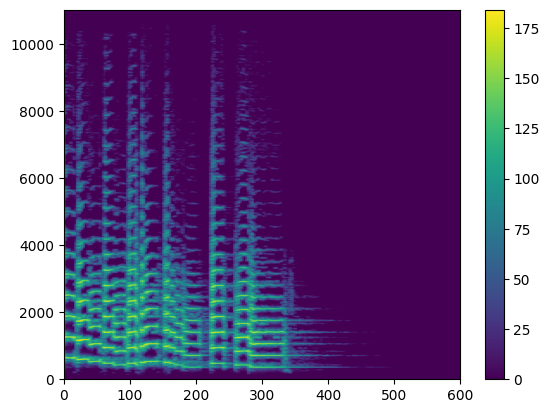

In [388]:
sample_rate=22050
w_fs=22050
n_fft=1024*2
max_freq=w_fs//2
thres_db=80 #below 60dB is not considered
#w_sgram = make_spectrogram(w_stft,int(1024*max_freq/w_fs),60)
w_sgram = make_spectrogram(w_stft,n_fft,thres_db, sample_rate)
plt.imshow(np.transpose(w_sgram), origin='lower',extent=(0,600,0,max_freq),aspect='auto')
plt.colorbar()

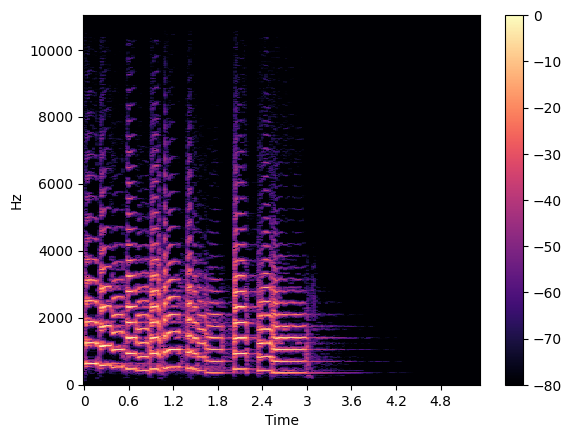

In [389]:
plt.figure()
librosa.display.specshow(Sdb, x_axis='time', y_axis='linear')
plt.colorbar()

# Creating the Mel-Frequency Cepstrum Coefficients (MFCC)

In [390]:
def freq_to_mel(freq):
    mel_scale=2595*np.log10(1+freq/700)
    return mel_scale

In [391]:
def mel_to_freq(mel):
    freq_scale=700 * (10**(mel/2595) - 1)
    return freq_scale

In [392]:
def mel_filterbank(n_filters,sample_rate,n_fft):
    
    #frequency range
    low_freq = 0
    high_freq = sample_rate//2
    
    #mel-range, from frequency to mel
    min_mel=freq_to_mel(low_freq)
    max_mel=freq_to_mel(high_freq)
    
    #create the x-axis of mel_filterbank
    mel_pts=np.linspace(min_mel,max_mel,2+n_filters)
    
    #convert from mel to frequency
    freq_pts=mel_to_freq(mel_pts)
    
    #freq to fft_bins conversion
    #fft_bins=(((1+n_fft)*freq_pts)//sample_rate).astype(np.int32)
    fft_bins=(((1+n_fft)*freq_pts)//sample_rate).astype(np.int32)
    
    mel_filter_bank=np.zeros((n_filters,1+n_fft//2))
    for i in range(1,n_filters+1):
        f_m_minus=fft_bins[i-1]
        f_m=fft_bins[i]
        f_m_plus=fft_bins[i+1]
        
        for j in range(f_m_minus,f_m):
            mel_filter_bank[i-1,j]=(j-fft_bins[i-1])/ (fft_bins[i] - fft_bins[i - 1])
            
        for j in range(f_m,f_m_plus):
            mel_filter_bank[i-1,j]=(fft_bins[i + 1] - j) / (fft_bins[i + 1] - fft_bins[i])
            
    
    mel_filter_bank=mel_filter_bank.T
    #mel_filter = mel_filter_bank.T / mel_filter_bank.sum(axis=1).clip(1e-16)
    
    return mel_filter_bank

In [395]:
def make_mel_spectrogram(segments,sample_rate,n_fft,n_filters):
    
    #short-term-fourier-transform
    fft_segments,freq_bins = STFT(segments=segments,sample_rate=22050,n_fft=2048)
    
    # create the spectrogram
    spec=make_spectrogram(fft_segments,n_fft,thres_db,sample_rate)
    
    #create the mel-filter-bank
    mel_filter=mel_filterbank(n_filters,sample_rate,n_fft)
    
    # project the spectrogram onto the mel-basis
    proj_mel=np.dot(spec,mel_filter)
    
    mel_spec=proj_mel.T
    
    return mel_spec

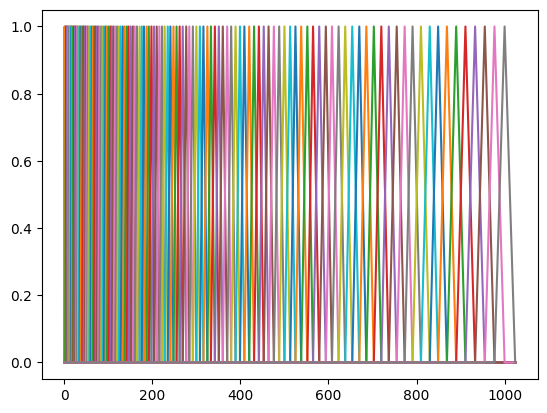

In [357]:
mel_filter= mel_filterbank(128,22050,2048)
plt.plot(mel_filter)
plt.show()

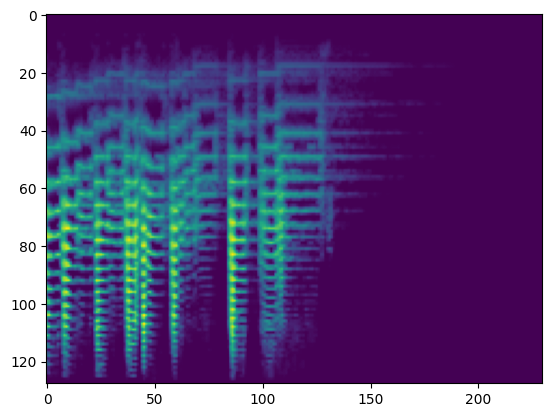

In [400]:
#Testing the funtion: make_mel_spectrogram
#would need to fix the oriebtation of the plot(flip the entire plot)
segments=segments
sample_rate=22050
n_fft=2048
n_filters=128

mel_spec=make_mel_spectrogram(segments,sample_rate,n_fft,n_filters)
plt.imshow(mel_spec, aspect='auto')

In [358]:
mel_filter.shape


(1025, 128)

In [384]:
np.array(w_sgram).shape

(230, 1025)

In [393]:
np.dot(w_sgram,mel_filter).shape

(230, 128)

In [360]:
product=np.dot(mel_filter.T,np.array(w_sgram).T)
product.shape

(128, 230)

In [ ]:
max_freq_bins=(max_freq*n_fft)//sample_rate

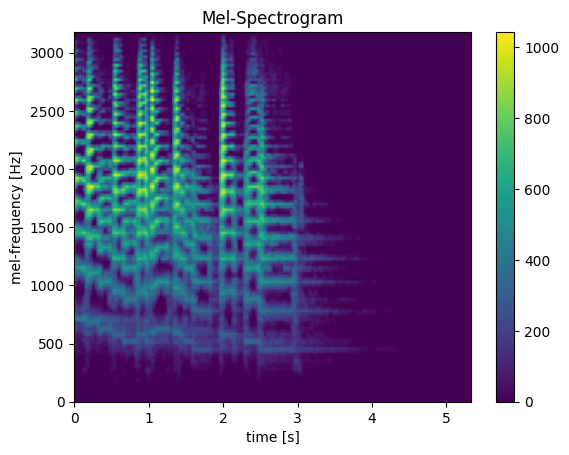

In [383]:
sample_rate=22050
total_sec=len(y)/sample_rate
high_freq=sample_rate//2
max_mel=freq_to_mel(high_freq)
plt.imshow(product,aspect='auto',origin='lower',extent=(0,total_sec,0,max_mel))
plt.ylabel('mel-frequency [Hz]')
plt.xlabel('time [s]')
plt.title('Mel-Spectrogram')
plt.colorbar()
plt.show()

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

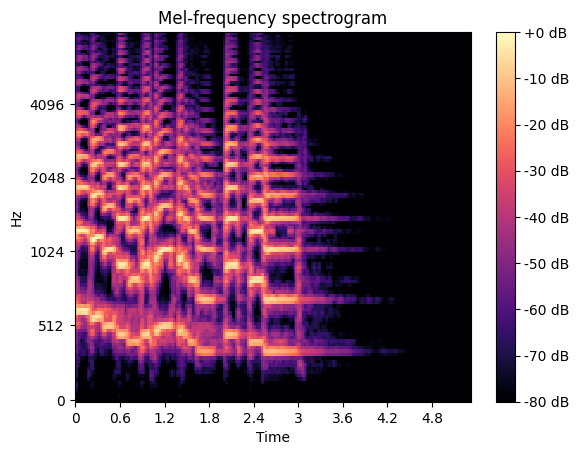

In [362]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Speech Recognition

In [66]:
(22050/(2048//4))*1000

43066.40625

10.75609756097561

In [60]:
stft.shape #outputs (1+n_fft/2, 22050)

(1025, 5163)

In [21]:
#Get the duration of how long the audio is 
duration = librosa.get_duration(y=y, sr=22050, S=None, n_fft=2048, hop_length=512)
print(f'duration of the audio is {duration}')

# The number of points in the audio, this will return the length of y 
print(duration * sample_rate)

duration of the audio is 119.87591836734694
2643264.0


In [29]:
mag_y = np.abs(librosa.stft(y))

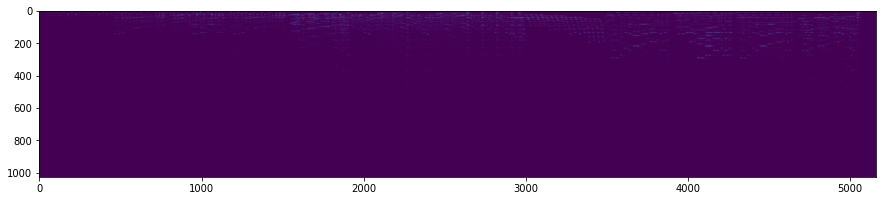

In [33]:
plt.figure(figsize=(15,10))
plt.imshow(mag_y)

In [10]:
librosa.get_duration(y)

119.87591836734694

In [11]:
sr = 22050

y_sweep = librosa.chirp(fmin=librosa.note_to_hz('C3'),
                        fmax=librosa.note_to_hz('C5'),
                        sr=sr,
                        duration=1)

Audio(data=y_sweep, rate=sr)

In [12]:
y, sr = librosa.load(librosa.ex('trumpet'))

Audio(data=y, rate=sr)

In [13]:
# Using fill_na=None retains the best-guess f0 at unvoiced frames
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             sr=sr,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'),
                                             fill_na=None)

# To synthesize the f0, we'll need sample times
times = librosa.times_like(f0)

In [14]:
vneg = (-1)**(~voiced_flag)

# And sonify the f0 using mir_eval
y_f0 = mir_eval.sonify.pitch_contour(times, f0 * vneg, sr)

Audio(data=y_f0, rate=sr)


In [15]:
# Compute the onset strength envelope, using a max filter of 5 frequency bins
# to cut down on false positives
onset_env = librosa.onset.onset_strength(y=y, sr=sr, max_size=5)

# Detect onset times from the strength envelope
onset_times = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, units='time')

# Sonify onset times as clicks
y_clicks = librosa.clicks(times=onset_times, length=len(y), sr=sr)

Audio(data=y+y_clicks, rate=sr)